## Importing Libraries

In [ ]:
#importing libraries

import pandas as pd
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import tarfile
from io import BytesIO
from typing import Optional, Tuple
import sklearn.datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import mutual_info_classif

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np


from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import re
import time
import os
from typing import Optional, Tuple

from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

import sys
import random as rn
import torch
from torch import nn
!pip install --upgrade "botocore>=1.34.41,<1.34.52"
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)



## Data Downloading

In [ ]:
def fetch_imdb_reviews(download_dir: str):
    """Fetch IMDB Movie Review data and save it to :download_dir:"""

    response = requests.get('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')

    # Check if the request was successful (status code 200) and extract the contents to :donwload_dir:
    if response.status_code == 200:

        tar_file = tarfile.open(fileobj=BytesIO(response.content), mode="r:gz")
        tar_file.extractall(path=download_dir)

        tar_file.close()

        print("Extraction completed.")
    else:
        print(f"Failed to download the tar file. Status code: {response.status_code}")



In [ ]:
download_dir = './'

fetch_imdb_reviews(download_dir)  # if successful, you should see a new folder called aclImdb in :download_dir:

Extraction completed.


## Baseline models LR, RF, XGBoost (Data prepration, Model creation, Experiments)


### Data Preprocessing

Filter Features - BoW .feat Files  
- Working on dealing with the BoW .feat files and accessing the data contained in them

In [ ]:
def find_rare_stopwords(aclImdb_dir: str):
    vocab_file_path = os.path.join(aclImdb_dir, 'imdb.vocab')
    with open(vocab_file_path, 'r', encoding='utf-8') as file:
        words = file.readlines()
        words = [word.strip() for word in words]

    bow_file_path = os.path.join(aclImdb_dir, 'train/labeledBow.feat')
    with open(bow_file_path, 'r', encoding='utf-8') as file:
        features_rates = file.readlines()
        features_rates = [line.strip() for line in features_rates]
        num_features = len(words)
        num_data = len(features_rates)
        featues_repeatance = np.zeros((num_features))
        for i in range(len(features_rates)):
            pairs = re.findall(r'(\d+:\d+)', features_rates[i])
            pairs_list = [tuple(map(int, pair.split(':'))) for pair in pairs]
            for j in range(len(pairs_list)):
                featues_repeatance[pairs_list[j][0]] += 1

        featues_repeatance /= num_data

        # checking for rare words and stoppped words (<1% and >50%)
        selected_inds = np.where((featues_repeatance <= 0.5) & (featues_repeatance >= 0.01))
        selected_words =  np.array(words)[selected_inds[0]]
    return selected_inds[0], selected_words

polarized_words, polarized_words_str = find_rare_stopwords('./aclImdb')
print(len(polarized_words))
print(len(polarized_words_str))

1744
1744


In [ ]:
def features_generator(aclImdb_dir: str, train_test):
    vocab_file_path = os.path.join(aclImdb_dir, 'imdb.vocab')
    with open(vocab_file_path, 'r', encoding='utf-8') as file:
        words = file.readlines()
        words = [word.strip() for word in words]
    if train_test == 'train':
        bow_file_path = os.path.join(aclImdb_dir, 'train/labeledBow.feat')
    else:
        bow_file_path = os.path.join(aclImdb_dir, 'test/labeledBow.feat')

    with open(bow_file_path, 'r', encoding='utf-8') as file:
        features_rates = file.readlines()
        features_rates = [line.strip() for line in features_rates]

    polarized_words, polarized_words_str = find_rare_stopwords(aclImdb_dir)
    # print(polarized_words.shape)
    polarized_words_dict = {index: value for index, value in enumerate(polarized_words)}
    polarized_words_inverted_dict = dict(map(reversed, polarized_words_dict.items()))
    num_features = len(polarized_words)
    num_data = len(features_rates)
    features_values =  np.zeros((num_data, num_features))
    ratings_vector  = np.zeros((num_data))
    for i in range(len(features_rates)):
        pairs = re.findall(r'(\d+:\d+)', features_rates[i])
        for pair in pairs:
            tup = tuple(map(int, pair.split(':')))
            if tup[0] in polarized_words_dict.values():
                features_values[i,polarized_words_inverted_dict[tup[0]]] = tup[1]
                ratings_vector[i] = features_rates[i][0]
    return features_values, ratings_vector, polarized_words_str

x, y, polarized_words_str = features_generator('./aclImdb', 'train')
print(polarized_words_str)

['he' 'his' '!' ... 'opens' 'essentially' 'received']


In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w                             #predict the y values
        return yh


In [ ]:
def standardization(x, test = False, train_mean = None, train_std = None):
    if test:
      # Standardize the test feature matrix with mean and std of train
      x_standardized = (x - train_mean) / train_std

    # Standardize the feature matrix
    x_standardized = (x - x.mean(axis=0)) / x.std(axis=0)
    return x_standardized

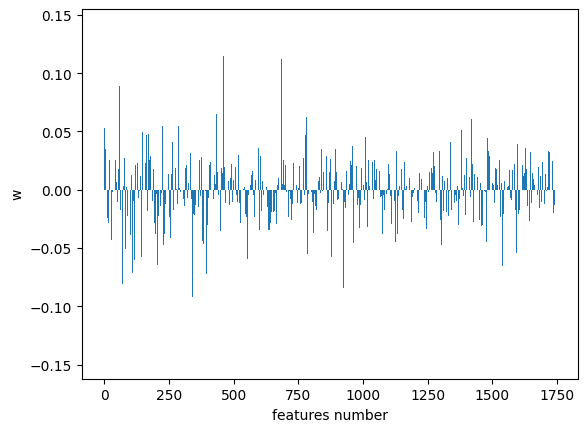

[-0.05820662  0.05325801 -0.09668227 ...  0.01302959 -0.02337913
  3.7742    ]


In [ ]:
# Applying linear regression on the training data to find important features
x_training, y_training, polarized_words_str = features_generator('./aclImdb', 'train')
num_features = x_training.shape[1]
x_standardized_training = standardization(x_training)
model_linear = LinearRegression()
yh = model_linear.fit(x_standardized_training,y_training).predict(x_standardized_training)
plt.bar(np.arange(num_features), model_linear.w[:-1])
plt.xlabel('features number')
plt.ylabel('w')
plt.show()
print(model_linear.w)

Printing the result in a tabular format for 10 important featurs overall
     String              |              Number     
---------------------------------------------------
      bad                |          -0.14764036167376354
      fun                |          0.14051545952426342
     good                |          0.13602031048533547
     waste               |          -0.1238960277517756
     worst               |          -0.12014350063124399
    enjoyed              |          0.11514356276501186
     liked               |          0.11394600790617399
   enjoyable             |          0.11224975974079435
     great               |          0.10812952528542158
     worth               |          0.1005638946320224
Printing the result in a tabular format for 10 positively important featurs
---------------------------------------------------
      fun                |          0.14051545952426342
     good                |          0.13602031048533547
    enjoyed           

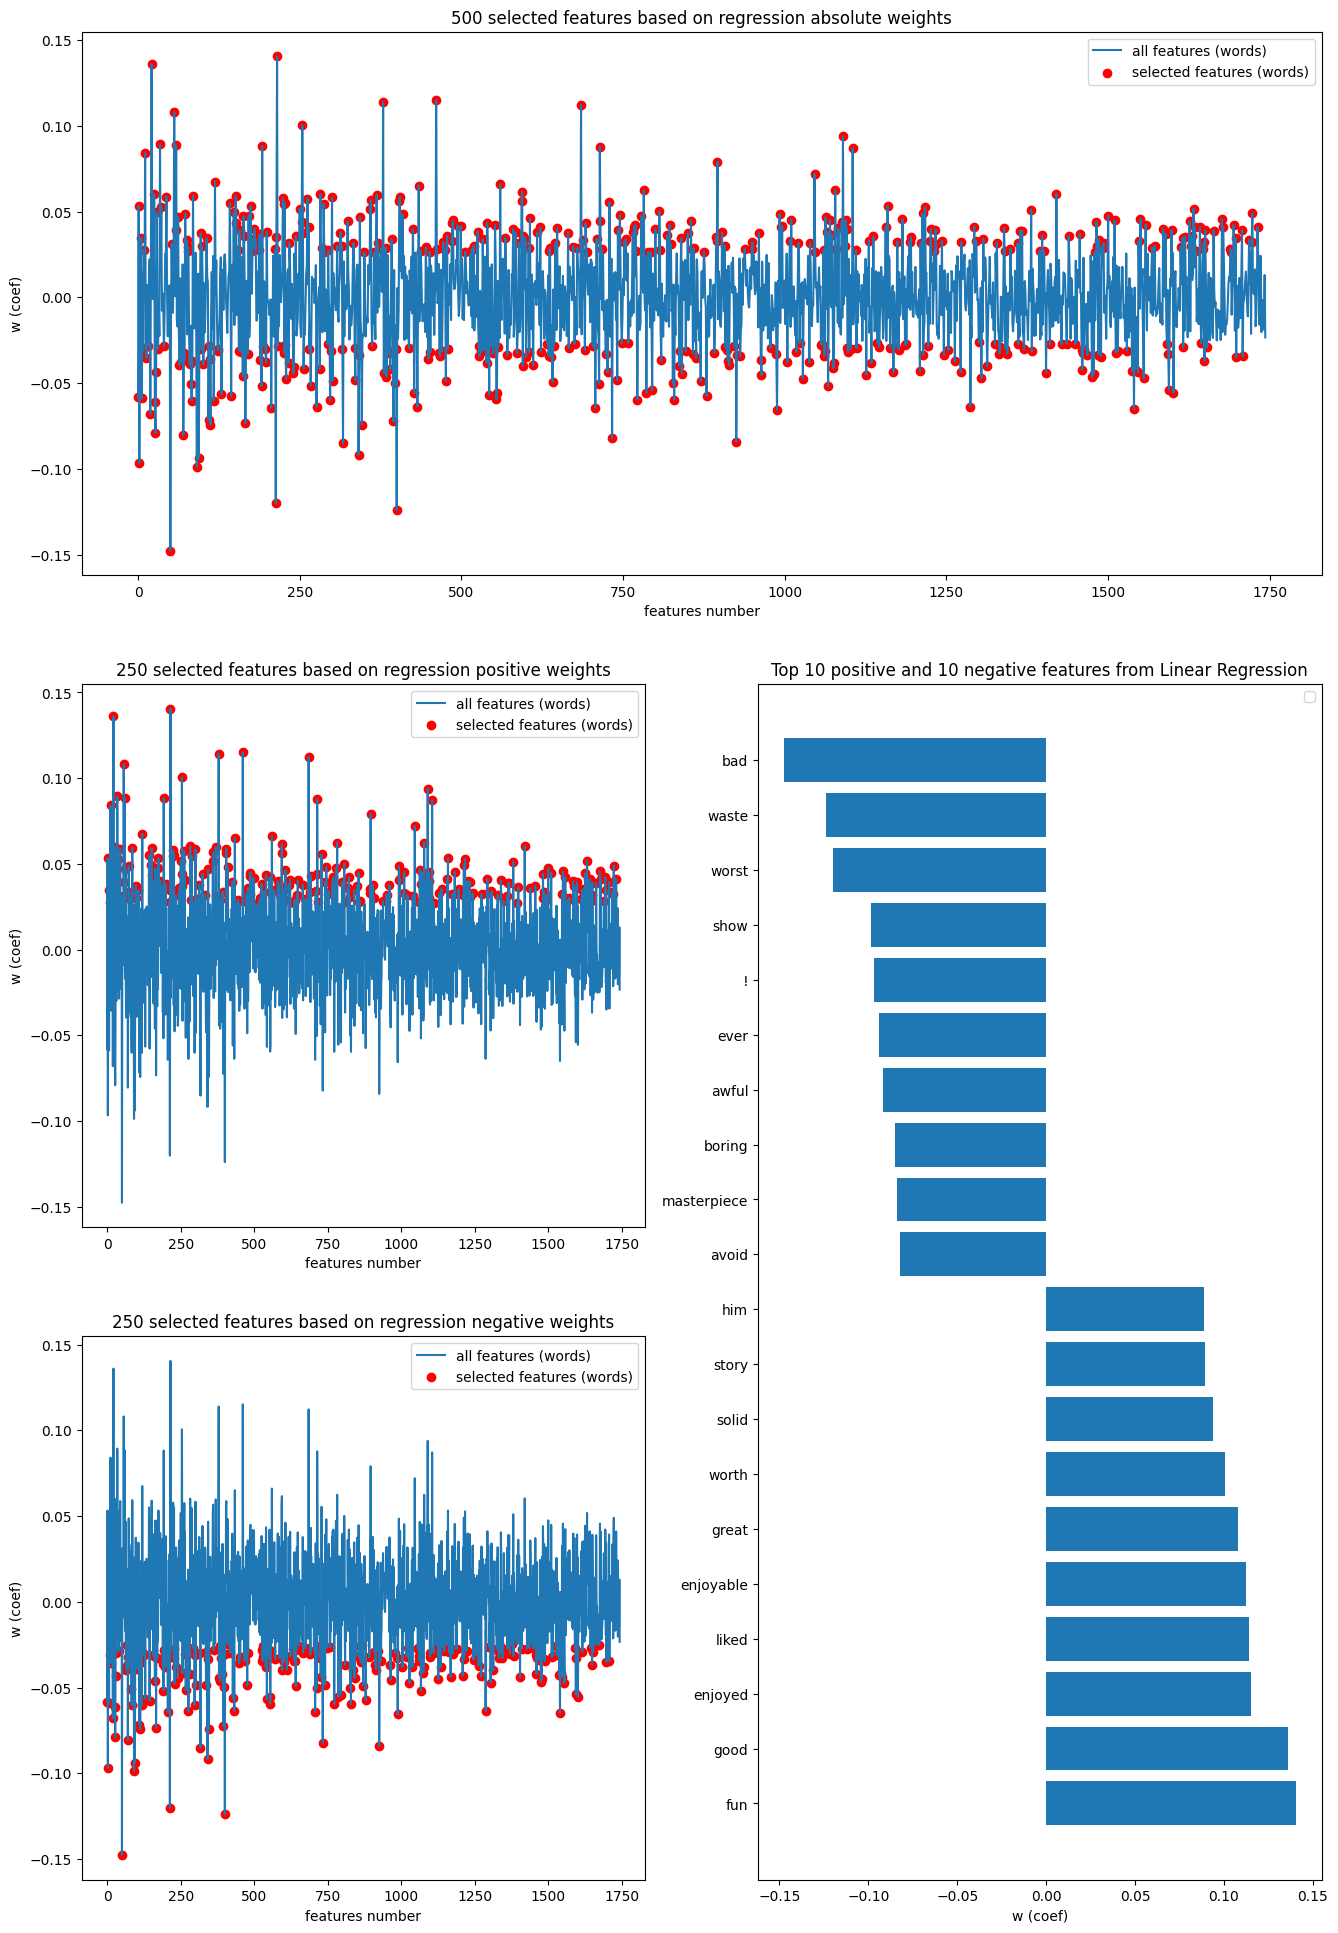

In [ ]:
num_features_vec = np.arange(num_features)
weights_vec = model_linear.w[:-1]
# Get the indices that would sort the data in descending order
sorted_indices = np.argsort(abs(weights_vec))[::-1]       # Sorting indices based on the abs values of weights
sorted_indices_pos = np.argsort(weights_vec)[::-1]        # Sorting indices based on the values of weights (to collect highest positive ones)
sorted_indices_neg = np.argsort(weights_vec)              # Sorting indices based on the negative values of weights (to collect highest negative ones)

# Collect  the 500 highest abs weights
sorted_num_features_vec = num_features_vec[sorted_indices]
selected_features = sorted_num_features_vec[:500]
sorted_weights_vec = weights_vec[sorted_indices]
selected_weights = sorted_weights_vec[:500]

# Collect  the 500 highest pos weights
sorted_num_features_vec_pos = num_features_vec[sorted_indices_pos]
selected_features_pos = sorted_num_features_vec_pos[:250]
sorted_weights_vec_pos = weights_vec[sorted_indices_pos]
selected_weights_pos = sorted_weights_vec_pos[:250]

# Collect  the 500 highest neg weights
sorted_num_features_vec_neg = num_features_vec[sorted_indices_neg]
selected_features_neg = sorted_num_features_vec_neg[:250]
sorted_weights_vec_neg = weights_vec[sorted_indices_neg]
selected_weights_neg = sorted_weights_vec_neg[:250]

plt.figure(figsize=(16, 24))
plt.subplot(3,2,(1,2))
# Plot the selected features based on regression abs weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features, selected_weights, color='r', label = 'selected features (words)')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.title('500 selected features based on regression absolute weights')
plt.legend()


# Printing the result in a tabular format for 10 important featurs overall
print('Printing the result in a tabular format for 10 important featurs overall')
print("     String              |              Number     ")
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features[:10]],selected_weights[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,3)
# Plot the selected features based on regression high positive weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features_pos, selected_weights_pos,color='r', label = 'selected features (words)')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.title('250 selected features based on regression positive weights')
plt.legend()

# Printing the result in a tabular format for 10 positively important featurs
print('Printing the result in a tabular format for 10 positively important featurs')
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features_pos[:10]],selected_weights_pos[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,5)
# Plot the selected features based on regression high negative weights
plt.plot(num_features_vec, weights_vec, label = 'all features (words)')
plt.scatter(selected_features_neg, selected_weights_neg,color='r', label = 'selected features (words)')
plt.title('250 selected features based on regression negative weights')
plt.xlabel('features number')
plt.ylabel('w (coef)')
plt.legend()


# Printing the result in a tabular format for 10 negatively important featurs
print('Printing the result in a tabular format for 10 negatively important featurs')
print("---------------------------------------------------")
for row in list(zip(polarized_words_str[selected_features_neg[:10]],selected_weights_neg[:10])):
    print(f"{row[0]:^15}          |          {row[1]:^15}")

plt.subplot(3,2,(4,6))
# Plot top pos and neg weights in a bar plot
topweights = np.concatenate([selected_weights_pos[:10],selected_weights_neg[:10]])
topfeatures = np.concatenate([polarized_words_str[selected_features_pos[:10]],polarized_words_str[selected_features_neg[:10]]])
indices = np.argsort(topweights)[::-1]
sorted_topfeatures = topfeatures[indices]
sorted_topweights = topweights[indices]
plt.barh(sorted_topfeatures, sorted_topweights)
plt.title('Top 10 positive and 10 negative features from Linear Regression')
plt.xlabel('w (coef)')
plt.legend()
# plt.savefig(f'imdb_features_pos-neg20.png', bbox_inches='tight')
plt.show()
# files.download(f'imdb_features_pos-neg20.png')

In [ ]:
# Preparing the train and validation data
x_selected_training = x_training[:,selected_features]
y_binary_training = (y_training>5).astype(int)

x_train, x_valid, y_train, y_valid = train_test_split(standardization(x_selected_training), y_binary_training, test_size=0.3, random_state=42)
print("input characteristics:",x_train.min(), x_train.max(), x_train.mean(),y_train.min(), y_train.max())

input characteristics: -0.6801951067237103 96.02738791216366 0.00011579169617409846 0 1


In [ ]:
# Preparing the train and validation data
x_selected_training = x_training[:,selected_features]
y_binary_training = (y_training>5).astype(int)

x_train, y_train = standardization(x_selected_training), y_binary_training
print("input characteristics:",x_train.min(), x_train.max(), x_train.mean(),y_train.min(), y_train.max())

input characteristics: -0.6801951067237103 96.02738791216366 1.1095835361629724e-18 0 1


In [ ]:
# Preparing the test data
x_testing, y_testing, _ = features_generator('./aclImdb', 'test')
x_standardized_testing = standardization(x_testing, True, x_training.mean(axis=0),x_training.std(axis=0))
x_test = x_standardized_testing[:,selected_features]
# print(sum(y_testing ==5))
y_test = (y_testing>5).astype(int)

### LR hyperpameters

In [ ]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(solver='sag', random_state=42)

param_grid = {
    'max_iter': [50, 100, 200],  # Learning rates
    'C': [10000, 1000, 100, 10, 1, 0.1, 0.01]  # Inverse of regularization strengths
}

# Perform grid search
grid_search = GridSearchCV(estimator=logisticRegr, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search = grid_search.fit(x_train, y_train)

# Get the results as a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Rename the columns
results_df = results_df.rename(columns={'mean_test_score': 'mean_valid_score', 'std_test_score': 'std_valid_score'})

# Extract relevant columns
results = results_df[['param_max_iter', 'param_C', 'mean_valid_score', 'std_valid_score']]

# Print results in tabular format
print(tabulate(results, headers='keys', tablefmt='psql'))

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
+----+------------------+-----------+--------------------+-------------------+
|    |   param_max_iter |   param_C |   mean_valid_score |   std_valid_score |
|----+------------------+-----------+--------------------+-------------------|
|  0 |               50 |  10000    |            0.74228 |         0.0940837 |
|  1 |              100 |  10000    |            0.74228 |         0.0940837 |
|  2 |              200 |  10000    |            0.74228 |         0.0940837 |
|  3 |               50 |   1000    |            0.74228 |         0.0940837 |
|  4 |              100 |   1000    |            0.74228 |         0.0940837 |
|  5 |              200 |   1000    |            0.74228 |         0.0940837 |
|  6 |               50 |    100    |            0.74228 |         0.0940837 |
|  7 |              100 |    100    |            0.74228 |         0.0940837 |
|  8 |              200 |    100    |            0.74228 |         0.

### LR best config train and test performance

In [ ]:
logisticRegr = LogisticRegression(solver='sag', C=0.01, max_iter=50, random_state=42)
logisticRegr.fit(x_train, y_train)
train_acc = logisticRegr.score(x_train, y_train)
print("Train Accuracy:", train_acc)
test_acc = logisticRegr.score(x_test, y_test)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = logisticRegr.predict_proba(x_test)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(y_test, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 0.78828
Test Accuracy: 0.75792
Test AUROC: 0.8111407954528477


### RF hyperpameters

In [ ]:
# Step 4: Instantiate the Model (Naming it RF)
RF = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30, 50, 80, 100]   # Maximum depth of the trees
}

# Initialize the Random Forest classifier
RF = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the results as a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Rename the columns
results_df = results_df.rename(columns={'mean_test_score': 'mean_valid_score', 'std_test_score': 'std_valid_score'})

# Extract relevant columns
results = results_df[['param_n_estimators', 'param_max_depth', 'mean_valid_score', 'std_valid_score']]

# Print results in tabular format
print(tabulate(results, headers='keys', tablefmt='psql'))

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)


+----+----------------------+-------------------+--------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   mean_valid_score |   std_valid_score |
|----+----------------------+-------------------+--------------------+-------------------|
|  0 |                   50 |                   |            0.70776 |        0.0653809  |
|  1 |                  100 |                   |            0.71144 |        0.0631478  |
|  2 |                  150 |                   |            0.71248 |        0.0617218  |
|  3 |                  200 |                   |            0.71396 |        0.0617136  |
|  4 |                  500 |                   |            0.71336 |        0.0624854  |
|  5 |                   50 |                10 |            0.69164 |        0.00822231 |
|  6 |                  100 |                10 |            0.69148 |        0.00747754 |
|  7 |                  150 |                10 |            0.69224 |        0.00524656 |

### RF best config train and test performance

In [ ]:
RF = RandomForestClassifier(random_state=42, max_depth = 100, n_estimators = 500)
RF.fit(x_train, y_train)
train_acc = RF.score(x_train, y_train)
print("Train Accuracy:", train_acc)
test_acc = RF.score(x_test, y_test)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = RF.predict_proba(x_test)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(y_test, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 0.99972
Test Accuracy: 0.741
Test AUROC: 0.7951306780064809


### XGBoost hyperpameters

In [ ]:
# Step 4: Instantiate the Model
XGBoost = xgb.XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'lambda': [0.1, 1.0, 10.0, 100],         # L2 regularization term
    'max_depth': [3, 6, 9],              # Maximum depth of trees
    'n_estimators': [50, 100, 150, 200]       # Number of trees in the ensemble
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBoost, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the results as a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Rename the columns
results_df = results_df.rename(columns={'mean_test_score': 'mean_valid_score', 'std_test_score': 'std_valid_score'})

# Extract relevant columns
results = results_df[['param_n_estimators', 'param_max_depth', 'mean_valid_score', 'std_valid_score']]

# Print results in tabular format
print(tabulate(results, headers='keys', tablefmt='psql'))

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)



+----+----------------------+-------------------+--------------------+-------------------+
|    |   param_n_estimators |   param_max_depth |   mean_valid_score |   std_valid_score |
|----+----------------------+-------------------+--------------------+-------------------|
|  0 |                   50 |                 3 |            0.71292 |         0.0821074 |
|  1 |                  100 |                 3 |            0.72236 |         0.0915643 |
|  2 |                  150 |                 3 |            0.72428 |         0.0967294 |
|  3 |                  200 |                 3 |            0.72764 |         0.0956264 |
|  4 |                   50 |                 6 |            0.71912 |         0.0920795 |
|  5 |                  100 |                 6 |            0.7248  |         0.0953521 |
|  6 |                  150 |                 6 |            0.72616 |         0.0944494 |
|  7 |                  200 |                 6 |            0.72732 |         0.0967723 |

### XGBoost best config train and test performance

In [ ]:
XGBoost = xgb.XGBClassifier(random_state=42, max_depth=9, n_estimators=200, reg_lambda=100)
XGBoost.fit(x_train, y_train)
train_acc = XGBoost.score(x_train, y_train)
print("Train Accuracy:", train_acc)
test_acc = XGBoost.score(x_test, y_test)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = XGBoost.predict_proba(x_test)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(y_test, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 0.8738
Test Accuracy: 0.75276
Test AUROC: 0.8018093082569655


## LLM (Data prepration, Model creation, Experiments)

### LLM Class (Bert Model)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define BERT model for attention extraction
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True, output_attentions=True)


# Define BERT classifier model with attention
class BertClassifierWithAttention(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertClassifierWithAttention, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions=True)
        pooled_output = outputs.pooler_output
        logits = self.classifier(self.dropout(pooled_output))
        return logits, outputs.attentions

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data Preprocessing

In [ ]:
def load_imdb_reviews(aclImdb_dir: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load the data from the aclImdb folder into train and test datasets"""

    train_reviews = []
    train_sentiments = []
    for sentiment in ['pos', 'neg']:
        for filename in os.listdir(f'{aclImdb_dir}/train/{sentiment}'):
            # id_, rating = filename[:-4].split('_')
            with open(f'{aclImdb_dir}/train/{sentiment}/{filename}', 'r') as f:
                review = f.read()

            # if sentiment == 'neg':
            #   id = 12_500 + int(id_)
            # else:
            #   id = int(id_)

            train_reviews.append(review)
            train_sentiments.append(sentiment)
            # train_instances[id] = IMDBMovieReview(id, review, sentiment, rating=float(rating))
    train_df = pd.DataFrame({'text': train_reviews, 'sentiment': train_sentiments})
    train_df.to_csv('train_data.csv', index=False)

    test_reviews = []
    test_sentiments = []
    for sentiment in ['pos', 'neg']:
        for filename in os.listdir(f'{aclImdb_dir}/test/{sentiment}'):
            # id_, rating = filename[:-4].split('_')

            with open(f'{aclImdb_dir}/test/{sentiment}/{filename}', 'r') as file:
                review = file.read()

            # if sentiment == 'neg':
            #   id = 12_500 + int(id_)
            # else:
            #   id = int(id_)

            test_reviews.append(review)
            test_sentiments.append(sentiment)
            # test_instances[id] = IMDBMovieReview(id, review, sentiment, rating=float(rating))
    test_df = pd.DataFrame({'text': test_reviews, 'sentiment': test_sentiments})
    test_df.to_csv('test_data.csv', index=False)
    return train_df, test_df

    # return train_instances, test_instances

In [ ]:
train_df, test_df = load_imdb_reviews('./aclImdb')

# print(train_df)
# print(test_df)

In [ ]:
train_texts, train_labels = train_df['text'], train_df['sentiment']
test_texts, test_labels = test_df['text'], test_df['sentiment']
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, shuffle=True)
train_texts[0]

train_labels = np.array(train_labels) == 'pos'
valid_labels = np.array(valid_labels) == 'pos'
test_labels = np.array(test_labels) == 'pos'
train_labels.shape, valid_labels.shape, test_labels.shape, np.mean(train_labels), np.mean(valid_labels), np.mean(test_labels)

((20000,), (5000,), (25000,), 0.49925, 0.503, 0.5)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], valid_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))
print(train_tokens[0])
len(train_tokens), len(valid_tokens), len(test_tokens)

train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
# print(train_tokens_ids[0])
train_tokens_ids.shape, valid_tokens_ids.shape, test_tokens_ids.shape

train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Convert lists into tensors - train
train_input_ids = torch.tensor(train_tokens_ids)
train_attention_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_labels)
print(type(train_input_ids),type(train_attention_masks),type(train_labels))

# Convert lists into tensors - valid
valid_input_ids = torch.tensor(valid_tokens_ids)
valid_attention_masks = torch.tensor(valid_masks)
valid_labels = torch.tensor(valid_labels)
print(type(valid_input_ids),type(valid_attention_masks),type(valid_labels))

# Convert lists into tensors - test
test_input_ids = torch.tensor(test_tokens_ids)
test_attention_masks = torch.tensor(test_masks)
test_labels = torch.tensor(test_labels)
print(type(test_input_ids),type(test_attention_masks),type(test_labels))

['[CLS]', 'i', 'really', 'didn', "'", 't', 'like', 'this', 'film', '.', 'the', 'plot', 'was', 'very', 'predictable', '.', 'typical', 'american', 'plot', ',', 'i', "'", 'm', 'sorry', '.', 'guy', 'gets', 'the', 'girl', 'kind', 'of', 'thing', 'at', 'the', 'end', '.', 'and', 'london', 'has', 'a', 'mono', '##rail', '?', 'bank', 'of', 'london', '?', '?', '?', 'bank', 'of', 'england', 'is', 'what', 'it', 'really', 'is', '!', '!', '-', 'i', 'did', 'however', 'like', 'the', 'look', 'of', 'tracy', 'island', 'and', 'the', 'thunder', '##birds', 'themselves', '.', 'and', 'the', 'brit', '##s', 'were', 'bad', '##dies', '?', '(', 'apart', 'from', 'parker', 'and', 'lady', 'penelope', ')', 'what', 'was', 'up', 'with', 'that', '?', 'oh', 'and', 'they', 'kept', 'on', 'saying', 'stuff', 'like', '"', 'here', 'come', "'", 'the', 'thunder', '##birds', "'", '"', '-', 'but', 'it', 'was', 'never', 'known', 'as', "'", 'the', 'thunder', '##birds', "'", 'in', 'the', 'series', ',', 'why', 'do', 'that', '?', '?', 'i'

### LLM hyperparameters

In [ ]:
def train(model, optimizer, train_loader, valid_loader, criterion, num_epochs):
    losses_train = np.zeros((num_epochs))
    train_accs = np.zeros((num_epochs))
    losses_valid = np.zeros((num_epochs))
    valid_accs = np.zeros((num_epochs))
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        correct_preds = 0
        total_preds = 0
        # Training
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            # Transfer inputs, attention_mask, and labels to the GPU
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            logits, attention_matrices = model(input_ids, attention_mask)  # Index 0 to get only the logits
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

            # Compute training accuracy
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += len(labels)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        # Validation
        model.eval()
        val_preds = []
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = batch
                # Transfer inputs, attention_mask, and labels to the GPU
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.type(torch.LongTensor).to(device)

                logits, attention_matrices = model(input_ids, attention_mask)
                val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                loss = criterion(logits, labels)
                total_loss += loss.item()

        avg_valid_loss = total_loss / len(valid_loader)

        val_accuracy = accuracy_score(val_labels, val_preds)

        losses_train[epoch] = avg_train_loss
        train_accs[epoch] = train_accuracy
        losses_valid[epoch] = avg_valid_loss
        valid_accs[epoch] = val_accuracy
    return losses_train, train_accs, losses_valid, valid_accs

# Instantiate BERT classifier model with attention
num_labels = 2  # binary classification
model = BertClassifierWithAttention(bert_model, num_labels).to(device)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# optimizer and learning rate scheduler
num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
# loss function
criterion = nn.CrossEntropyLoss()


num_epochs = 3
batch_sizes = [16, 32, 64]
learning_rates = [0.1, 0.01, 0.001]

losses_train = np.zeros((len(batch_sizes), len(learning_rates), num_epochs))
train_accs = np.zeros((len(batch_sizes), len(learning_rates), num_epochs))
losses_valid = np.zeros((len(batch_sizes), len(learning_rates), num_epochs))
valid_accs = np.zeros((len(batch_sizes), len(learning_rates), num_epochs))
# print(losses_train.shape, train_accs.shape, losses_valid.shape, valid_accs.shape)

for i, batch_size in enumerate(batch_sizes):
    for j, lr in enumerate(learning_rates):
        # Create data loaders - train
        train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Create data loaders - valid
        valid_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        optimizer = AdamW(model.parameters(), lr=lr)
        # losses_train[i, j, :], train_accs[i, j, :], losses_valid[i, j, :], valid_accs[i, j, :] = train(LLM, optimizer, train_loader, valid_loader, criterion, num_epochs)
        losses_train1, train_accs1, losses_valid1, valid_accs1 = train(LLM, optimizer, train_loader, valid_loader, criterion, num_epochs)
        losses_train[i, j, :], train_accs[i, j, :], losses_valid[i, j, :], valid_accs[i, j, :] = losses_train1, train_accs1, losses_valid1, valid_accs1
        # Save the variables
#         np.save(f'losses_train{i,j}.npy', losses_train1)
#         np.save(f'train_accs{i,j}.npy', train_accs1)
#         np.save(f'losses_valid{i,j}.npy', losses_valid1)
#         np.save(f'valid_accs{i,j}.npy', valid_accs1)

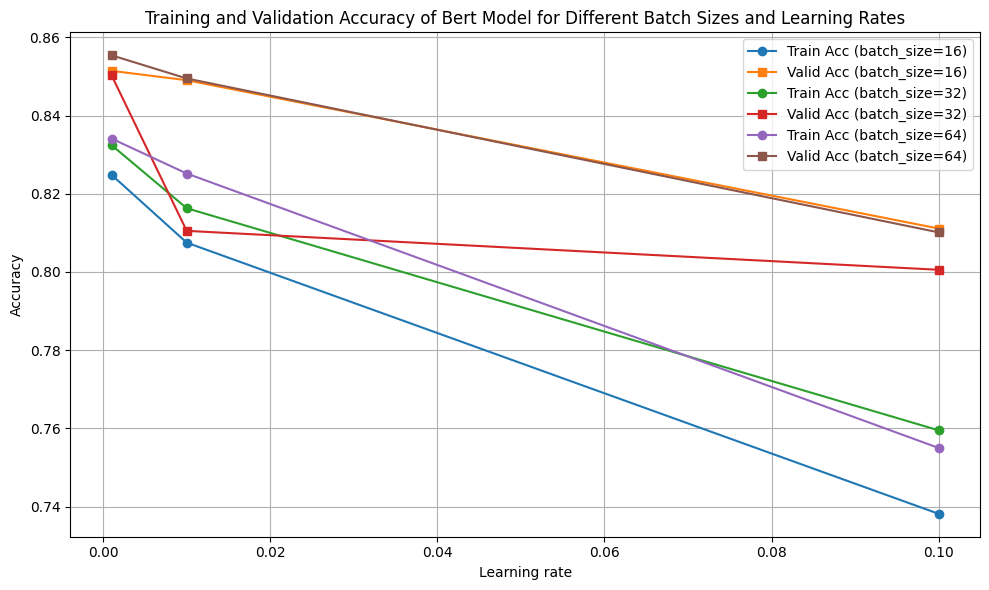

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))

for i, bs in enumerate(batch_sizes):
    plt.plot(learning_rates, train_accs[i,:,-1], marker='o', label=f'Train Acc (batch_size={bs})')
    plt.plot(learning_rates, valid_accs[i,:,-1], marker='s', label=f'Valid Acc (batch_size={bs})')

plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of Bert Model for Different Batch Sizes and Learning Rates')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig('hyper_LLM.png')

### LLM best configurations

In [ ]:
# Create datasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(valid_input_ids, valid_attention_masks, valid_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate BERT classifier model with attention
num_labels = 2  # binary classification
model = BertClassifierWithAttention(bert_model, num_labels).to(device)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Define optimizer and learning rate scheduler
num_epochs = 4
optimizer = AdamW(model.parameters(), lr=1e-3)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
criterion = nn.CrossEntropyLoss()


### LLM training, testing

In [ ]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    # Training
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        # Transfer inputs, attention_mask, and labels to the GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()
        logits, attention_matrices = model(input_ids, attention_mask)  # Index 0 to get only the logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Compute training accuracy
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += len(labels)

    # Print average loss and training accuracy
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    val_probs = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            # Transfer inputs, attention_mask, and labels to the GPU
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            logits, attention_matrices = model(input_ids, attention_mask)
            probs = torch.softmax(logits, dim=1)

            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class (good)

    val_accuracy = accuracy_score(val_labels, val_preds)
    val_roc_auc = roc_auc_score(val_labels, val_probs)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Validation AUROC: {val_roc_auc:.4f}")


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4, Average Training Loss: 0.5916, Training Accuracy: 0.6875


 25%|██▌       | 1/4 [13:41<41:03, 821.13s/it]

Validation Accuracy: 0.7884, Validation AUROC: 0.8674
Epoch 2/4, Average Training Loss: 0.5196, Training Accuracy: 0.7532


 50%|█████     | 2/4 [27:21<27:21, 820.85s/it]

Validation Accuracy: 0.7982, Validation AUROC: 0.8826
Epoch 3/4, Average Training Loss: 0.5021, Training Accuracy: 0.7629


 75%|███████▌  | 3/4 [41:03<13:41, 821.20s/it]

Validation Accuracy: 0.8152, Validation AUROC: 0.8911
Epoch 4/4, Average Training Loss: 0.4925, Training Accuracy: 0.7725


100%|██████████| 4/4 [54:44<00:00, 821.23s/it]

Validation Accuracy: 0.8140, Validation AUROC: 0.8934


In [ ]:
# Testing
model.eval()
test_preds = []
test_labels = []
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        # Transfer inputs, attention_mask, and labels to the GPU
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        logits, _ = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        test_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class (good)

test_accuracy = accuracy_score(test_labels, test_preds)
test_roc_auc = roc_auc_score(test_labels, test_probs)
print(f"Test Accuracy: {test_accuracy:.4f}, Test AUROC: {test_roc_auc:.4f}")


Test Accuracy: 0.8384, Test AUROC: 0.8840


### LLM attention matrix examination

In [ ]:
radom_pick = 629
sample_input_ids = torch.tensor(valid_tokens_ids[radom_pick:radom_pick+10,:]).to(device)
sample_attention_mask = torch.tensor(valid_masks[radom_pick:radom_pick+10]).to(device)
sample_labels = torch.tensor(valid_labels[radom_pick:radom_pick+10]).to(device)

print(sample_input_ids.shape, sample_attention_mask.shape, sample_labels.shape)

logits, attention_matrices = model(sample_input_ids, sample_attention_mask)


torch.Size([10, 512]) torch.Size([10, 512]) torch.Size([10])


Attention matrix for correctly predicted document:


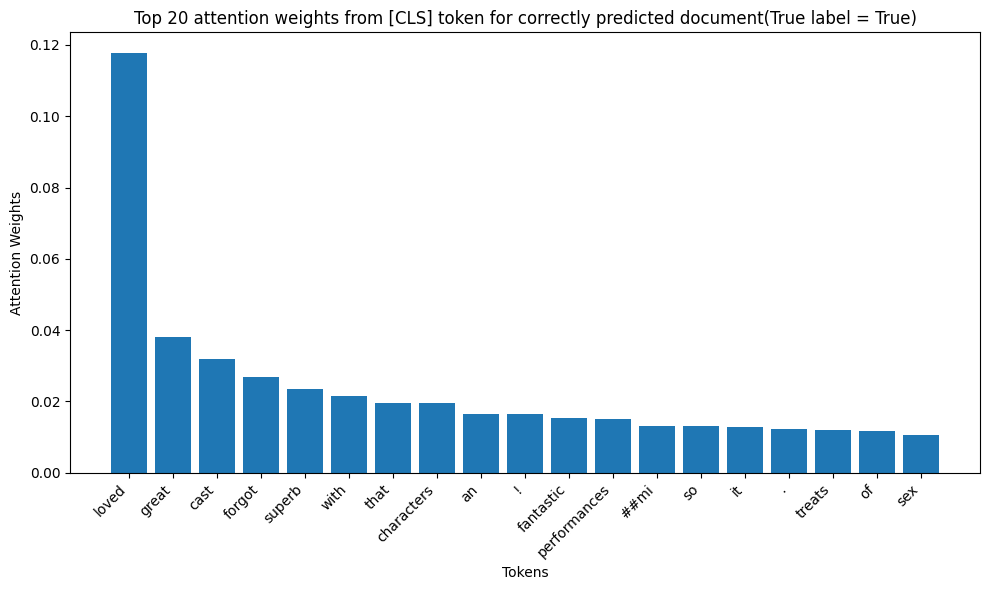

Attention matrix for incorrectly predicted document:


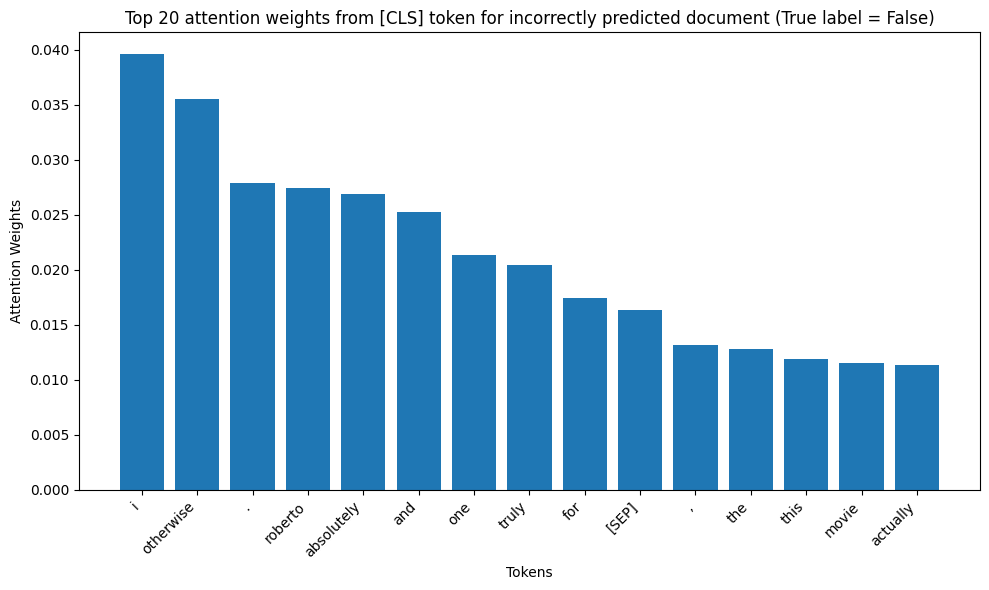

In [ ]:
predicted_labels = torch.argmax(logits, dim=1)
correctly_predicted_indices = torch.nonzero(predicted_labels == sample_labels.T)#[:,1]
incorrectly_predicted_indices = torch.nonzero(predicted_labels != sample_labels.T)#[:,1]

df = pd.DataFrame(columns = ['attentions', 'tokens'])
# Attention matrices for correctly predicted documents
for idx in correctly_predicted_indices:
    idx = int(idx)
    print("Attention matrix for correctly predicted document:")
    attention_matrix = attention_matrices[11][idx,9,0,1:]  # Shape: [num_layers(transformer_blocks), num_datapoints, num_heads, seq_len, seq_len]
    input_tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[idx])[1:512]
#     print(valid_texts[idx])
    df['attentions'] = attention_matrix.to("cpu")
    df['tokens'] = input_tokens
    df_selected = df.sort_values(by='attentions', ascending=False)[:20]
    plt.figure(figsize = (10,6))
    plt.bar(df_selected['tokens'], df_selected['attentions'])
    break
plt.xlabel('Tokens')
plt.ylabel('Attention Weights')
plt.title(f'Top 20 attention weights from [CLS] token for correctly predicted document(True label = {sample_labels[idx]})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('attention_weights_plot_correct.png')  # Save the plot as a PNG file
plt.show()

df = pd.DataFrame(columns = ['attentions', 'tokens'])
# Attention matrices for correctly predicted documents
for idx in incorrectly_predicted_indices:
    idx = int(idx)
    print("Attention matrix for incorrectly predicted document:")
    attention_matrix = attention_matrices[11][idx,9,0,1:]  # Shape: [num_layers(transformer_blocks), num_datapoints, num_heads, seq_len, seq_len]
    input_tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[idx])[1:512]
#     print(valid_texts[idx])
    df['attentions'] = attention_matrix.to("cpu")
    df['tokens'] = input_tokens
    df_selected = df.sort_values(by='attentions', ascending=False)[:20]
    plt.figure(figsize = (10,6))
    plt.bar(df_selected['tokens'], df_selected['attentions'])
    break
plt.xlabel('Tokens')
plt.ylabel('Attention Weights')
plt.title(f'Top 20 attention weights from [CLS] token for incorrectly predicted document (True label = {sample_labels[idx]})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('attention_weights_plot_incorrect.png')  # Save the plot as a PNG file
plt.show()

# Word2vec (wikipedia2vec) embedding

## Package installation and downloads


In [ ]:
!pip install wikipedia2vec

# # Download the Wikipedia dump file using wget (if you're using a Jupyter Notebook or Google Colab)
!wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2

!pip install bz2file


  Using cached bz2file-0.98-py3-none-any.whl


In [ ]:
import bz2
# Specify the paths
compressed_path = "enwiki_20180420_100d.pkl.bz2"
output_path = "enwiki_20180420_100d.pkl"
# Decompress the BZ2 file
with bz2.open(compressed_path, "rb") as f_in:
    with open(output_path, "wb") as f_out:
        f_out.write(f_in.read())

print(f"File saved as {output_path}")

File saved as enwiki_20180420_100d.pkl


## Data preperation using word2vec emmbedding

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import wikipedia2vec

# Load the pretrained Wikipedia2Vec embeddings (choose the appropriate file)
model_path = "enwiki_20180420_100d.pkl"
w2v_model = wikipedia2vec.Wikipedia2Vec.load(model_path)

max_tokens = 200
train_embeddings = []
for imdb_review_text in tqdm(train_texts):
    # Tokenize the review text
    imdb_review_tokens = word_tokenize(imdb_review_text.title())  # Convert to lowercase for consistency

    # Apply padding or truncation to each sentence
    if len(imdb_review_tokens) > max_tokens:
        # Truncate if too long
        imdb_review_tokens = imdb_review_tokens[:max_tokens]
    else:
        # Pad if too short
        padding = [' '] * (max_tokens - len(imdb_review_tokens))
        imdb_review_tokens = imdb_review_tokens + padding

    # Map tokens to embeddings
    text_embeddings = []
    for token in imdb_review_tokens:
        try:
            # print("salam")
            embedding = w2v_model.get_entity_vector(token)
            text_embeddings.append(embedding)
        except KeyError:
            # print('Error')
            # Handle tokens not found in the embeddings (e.g., out-of-vocabulary words)
            embedding = w2v_model.get_entity_vector(' ')
            text_embeddings.append(embedding)
            pass
    train_embeddings.append(text_embeddings)


valid_embeddings = []
for imdb_review_text in tqdm(valid_texts):
    # Tokenize the review text
    imdb_review_tokens = word_tokenize(imdb_review_text.title())  # Convert to lowercase for consistency

    # Apply padding or truncation to each sentence
    if len(imdb_review_tokens) > max_tokens:
        # Truncate if too long
        imdb_review_tokens = imdb_review_tokens[:max_tokens]
    else:
        # Pad if too short
        padding = [' '] * (max_tokens - len(imdb_review_tokens))
        imdb_review_tokens = imdb_review_tokens + padding

    # Map tokens to embeddings
    text_embeddings = []
    for token in imdb_review_tokens:
        try:
            embedding = w2v_model.get_entity_vector(token)
            text_embeddings.append(embedding)
        except KeyError:
            # Handle tokens not found in the embeddings (e.g., out-of-vocabulary words)
            embedding = w2v_model.get_entity_vector(' ')
            text_embeddings.append(embedding)
            pass

    valid_embeddings.append(text_embeddings)


test_embeddings = []
for imdb_review_text in tqdm(test_texts):
    # Tokenize the review text
    imdb_review_tokens = word_tokenize(imdb_review_text.title())  # Convert to lowercase for consistency

    # Apply padding or truncation to each sentence
    if len(imdb_review_tokens) > max_tokens:
        # Truncate if too long
        imdb_review_tokens = imdb_review_tokens[:max_tokens]
    else:
        # Pad if too short
        padding = [' '] * (max_tokens - len(imdb_review_tokens))
        imdb_review_tokens = imdb_review_tokens + padding

    # Map tokens to embeddings
    text_embeddings = []
    for token in imdb_review_tokens:
        try:
            embedding = w2v_model.get_entity_vector(token)
            text_embeddings.append(embedding)
        except KeyError:
            # Handle tokens not found in the embeddings (e.g., out-of-vocabulary words)
            embedding = w2v_model.get_entity_vector(' ')
            text_embeddings.append(embedding)
            pass

    test_embeddings.append(text_embeddings)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 25000/25000 [04:00<00:00, 104.13it/s]


In [ ]:
train_embeddings = np.array(train_embeddings)
train_embeddings = np.array(train_embeddings).reshape(len(train_embeddings),-1)

valid_embeddings = np.array(valid_embeddings)
valid_embeddings = np.array(valid_embeddings).reshape(len(valid_embeddings),-1)

test_embeddings = np.array(test_embeddings)
test_embeddings = np.array(test_embeddings).reshape(len(test_embeddings),-1)

print(train_embeddings.shape)

(20000, 20000)


## LR performance on embedded data

In [ ]:
logisticRegr = LogisticRegression(solver='sag', C=0.01, max_iter=50, random_state=42)
logisticRegr.fit(train_embeddings, train_labels)
train_acc = logisticRegr.score(train_embeddings, train_labels)
print("Train Accuracy:", train_acc)
valid_acc = logisticRegr.score(valid_embeddings, valid_labels)
print("Valid Accuracy:", valid_acc)
test_acc = logisticRegr.score(test_embeddings, test_labels)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = logisticRegr.predict_proba(test_embeddings)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(test_labels, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 0.9719
Valid Accuracy: 0.5934
Test Accuracy: 0.59268
Test AUROC: 0.6262574848


## RF performance on embedded data

In [ ]:
RF = RandomForestClassifier(random_state=42, max_depth = 100, n_estimators = 500)
RF.fit(train_embeddings, train_labels)
train_acc = RF.score(train_embeddings, train_labels)
print("Train Accuracy:", train_acc)
valid_acc = logisticRegr.score(valid_embeddings, valid_labels)
print("Valid Accuracy:", valid_acc)
test_acc = RF.score(test_embeddings, test_labels)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = RF.predict_proba(test_embeddings)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(test_labels, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 1.0
Valid Accuracy: 0.5934
Test Accuracy: 0.55224
Test AUROC: 0.5794580448


## XGBoost performance on embedded data

In [ ]:
XGBoost = xgb.XGBClassifier(random_state=42, max_depth=9, n_estimators=200, reg_lambda=100)
XGBoost.fit(train_embeddings, train_labels)
train_acc = XGBoost.score(train_embeddings, train_labels)
print("Train Accuracy:", train_acc)
valid_acc = logisticRegr.score(valid_embeddings, valid_labels)
print("Valid Accuracy:", valid_acc)
test_acc = XGBoost.score(test_embeddings, test_labels)
print("Test Accuracy:", test_acc)

# Make predictions
test_pred_probs = XGBoost.predict_proba(test_embeddings)[:, 1]  # Probability of positive class
# Compute AUROC
test_auroc = roc_auc_score(test_labels, test_pred_probs)
print("Test AUROC:", test_auroc)

Train Accuracy: 0.99965
Valid Accuracy: 0.5934
Test Accuracy: 0.56696
Test AUROC: 0.5938700863999999
